In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import zscore

In [2]:
print(torch.cuda.is_available())

True


In [3]:
# df = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv')
df = pd.read_csv('./train.csv')
df = df.drop(columns=['id'])
df.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 1117957 entries, 0 to 1117956

Data columns (total 21 columns):

 #   Column                           Non-Null Count    Dtype  

---  ------                           --------------    -----  

 0   MonsoonIntensity                 1117957 non-null  int64  

 1   TopographyDrainage               1117957 non-null  int64  

 2   RiverManagement                  1117957 non-null  int64  

 3   Deforestation                    1117957 non-null  int64  

 4   Urbanization                     1117957 non-null  int64  

 5   ClimateChange                    1117957 non-null  int64  

 6   DamsQuality                      1117957 non-null  int64  

 7   Siltation                        1117957 non-null  int64  

 8   AgriculturalPractices            1117957 non-null  int64  

 9   Encroachments                    1117957 non-null  int64  

 10  IneffectiveDisasterPreparedness  1117957 non-null  int64  

 11  DrainageSystems                  1

In [5]:
print("Duplicates: ",df.duplicated().sum(),"\n")
print("Null_values: ",df.isnull().sum(),"\n")
print("Shape: ", df.shape,"\n")

Duplicates:  0 



Null_values:  MonsoonIntensity                   0

TopographyDrainage                 0

RiverManagement                    0

Deforestation                      0

Urbanization                       0

ClimateChange                      0

DamsQuality                        0

Siltation                          0

AgriculturalPractices              0

Encroachments                      0

IneffectiveDisasterPreparedness    0

DrainageSystems                    0

CoastalVulnerability               0

Landslides                         0

Watersheds                         0

DeterioratingInfrastructure        0

PopulationScore                    0

WetlandLoss                        0

InadequatePlanning                 0

PoliticalFactors                   0

FloodProbability                   0

dtype: int64 



Shape:  (1117957, 21) 




In [6]:
df.MonsoonIntensity.value_counts().sort_index()

MonsoonIntensity
0       5431
1      28946
2      86683
3     160574
4     214344
5     220936
6     169080
7     109210
8      65954
9      33515
10     14040
11      5851
12      2062
13       729
14       391
15       169
16        42
Name: count, dtype: int64

In [7]:
df.columns

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')

In [8]:
df.describe()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,...,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,4.921450e+00,4.926671e+00,4.955322e+00,4.942240e+00,4.942517e+00,4.934093e+00,4.955878e+00,4.927791e+00,4.942619e+00,4.949230e+00,...,4.946893e+00,4.953999e+00,4.931376e+00,4.929032e+00,4.925907e+00,4.927520e+00,4.950859e+00,4.940587e+00,4.939004e+00,5.044803e-01
std,2.056387e+00,2.093879e+00,2.072186e+00,2.051689e+00,2.083391e+00,2.057742e+00,2.083063e+00,2.065992e+00,2.068545e+00,2.083324e+00,...,2.072333e+00,2.088899e+00,2.078287e+00,2.082395e+00,2.064813e+00,2.074176e+00,2.068696e+00,2.081123e+00,2.090350e+00,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,...,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.800000e+01,...,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.800000e+01,1.900000e+01,1.600000e+01,1.600000e+01,7.250000e-01


In [9]:
data = df.drop(columns=['FloodProbability'])
y = df[['FloodProbability']]

In [10]:
data.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3
1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3
2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3
3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5
4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5


In [11]:
y.head()

,FloodProbability
0,0.445
1,0.450
2,0.530
3,0.535
4,0.415


# EDA

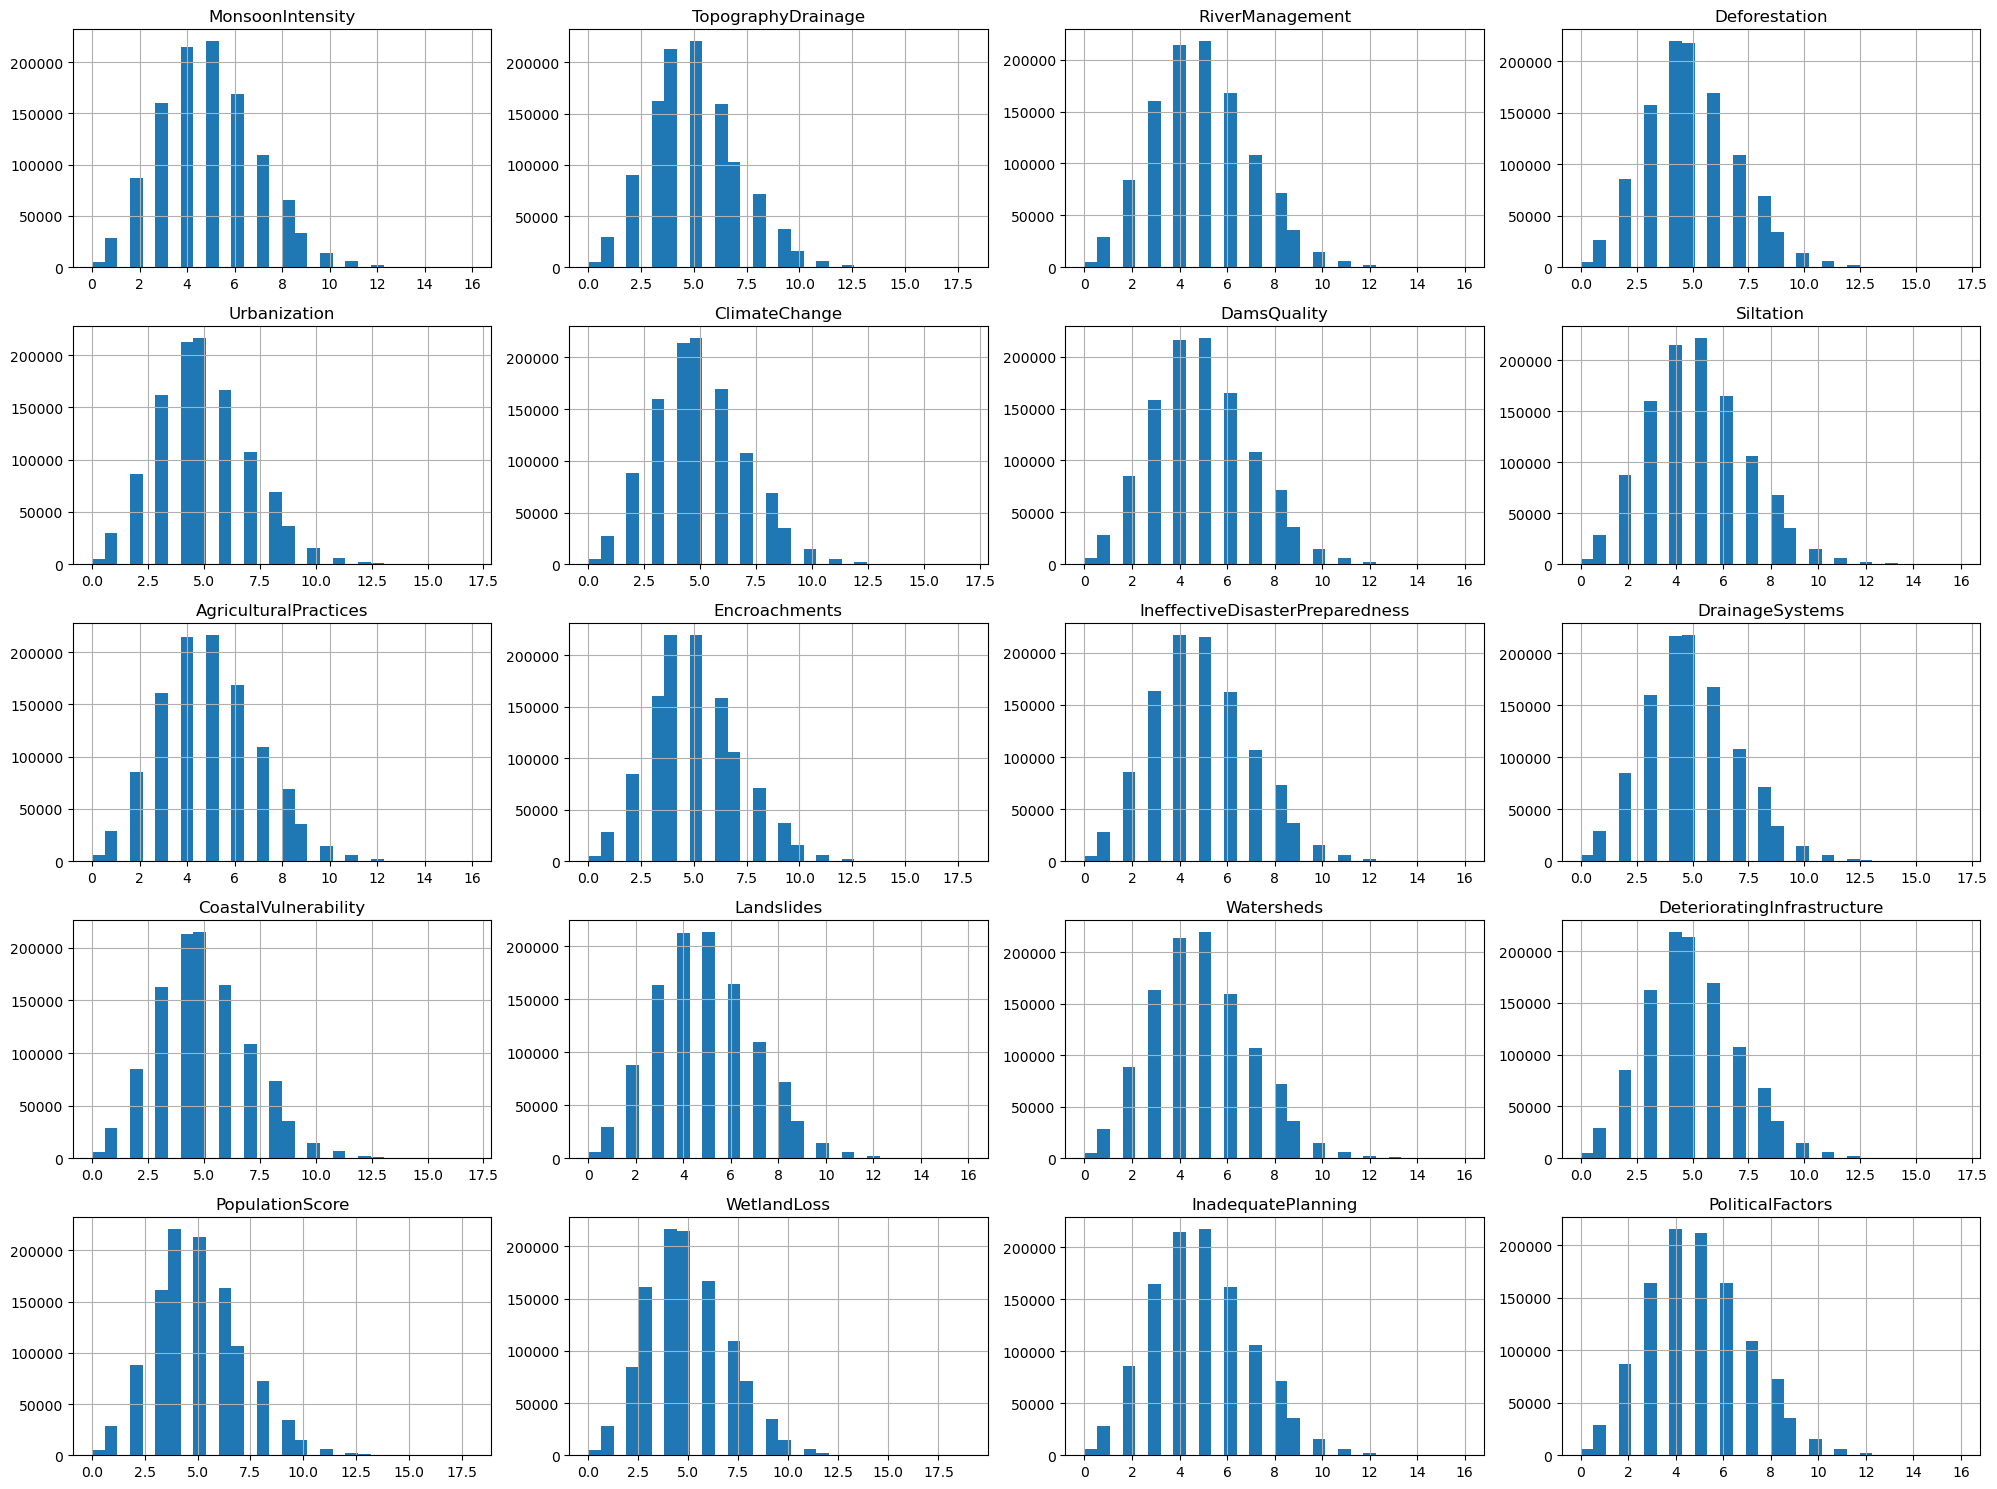

In [38]:
# Histograms # following normal distribution
# is in normal distribution apply zscore
data.hist(bins=30, figsize=(20, 15))
plt.tight_layout()
plt.show()

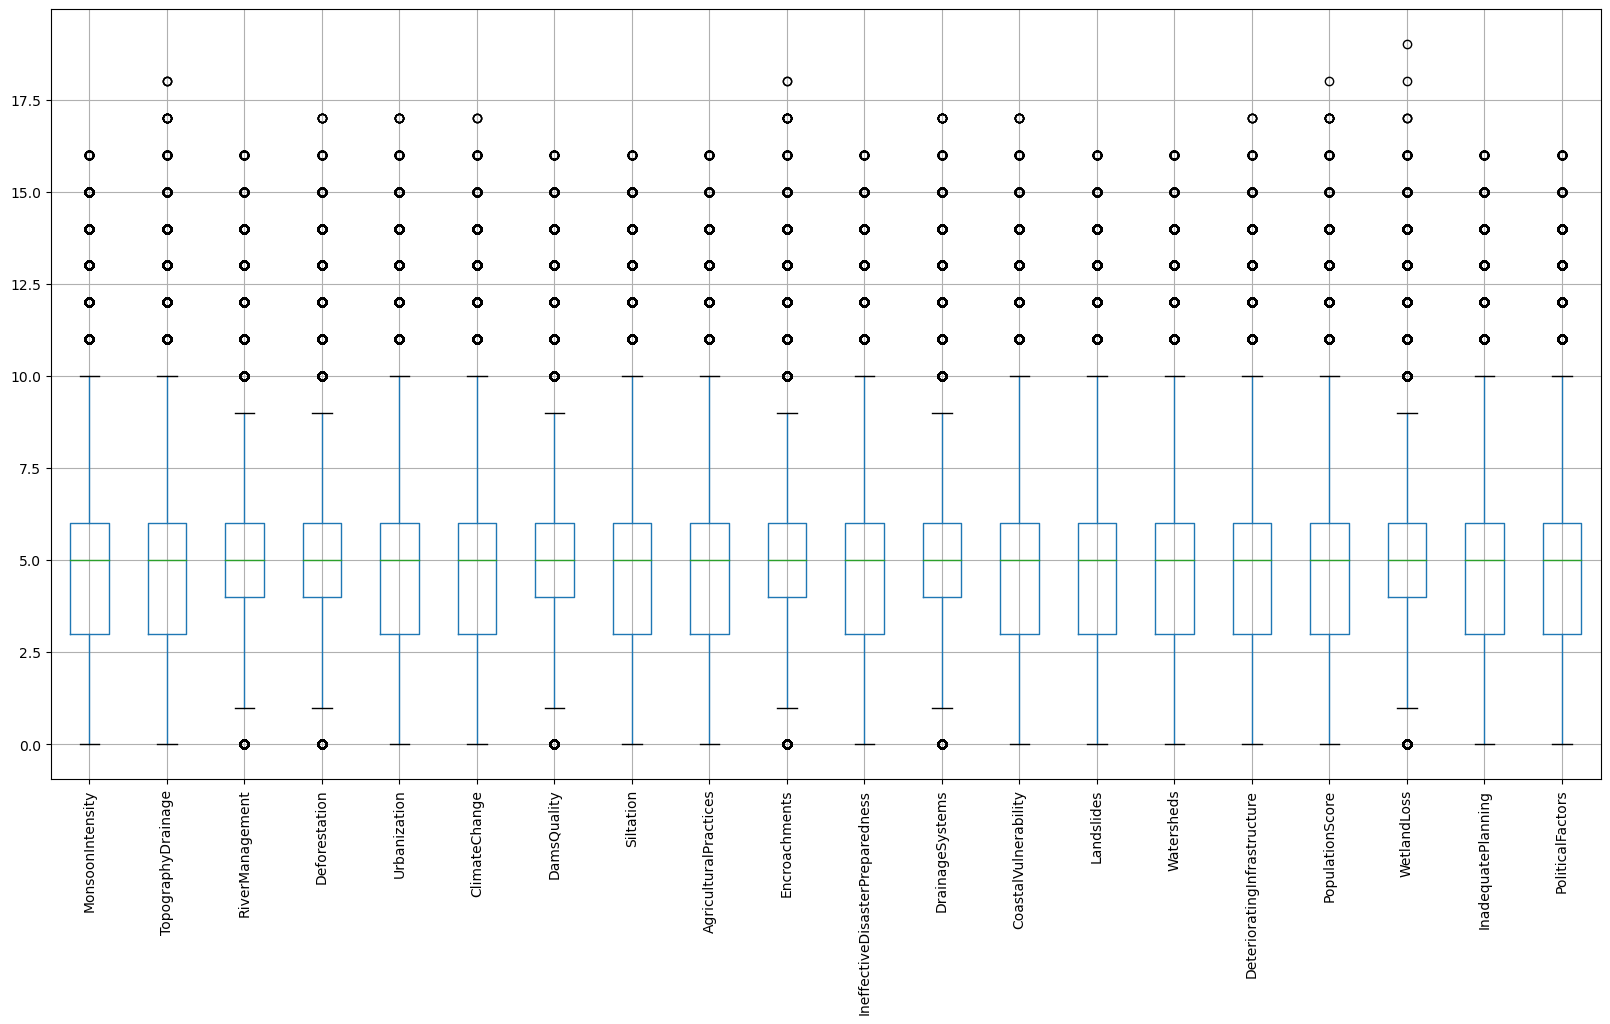

In [26]:
# Box plots
plt.figure(figsize=(20, 10))
data.boxplot()
plt.xticks(rotation=90)
plt.show()

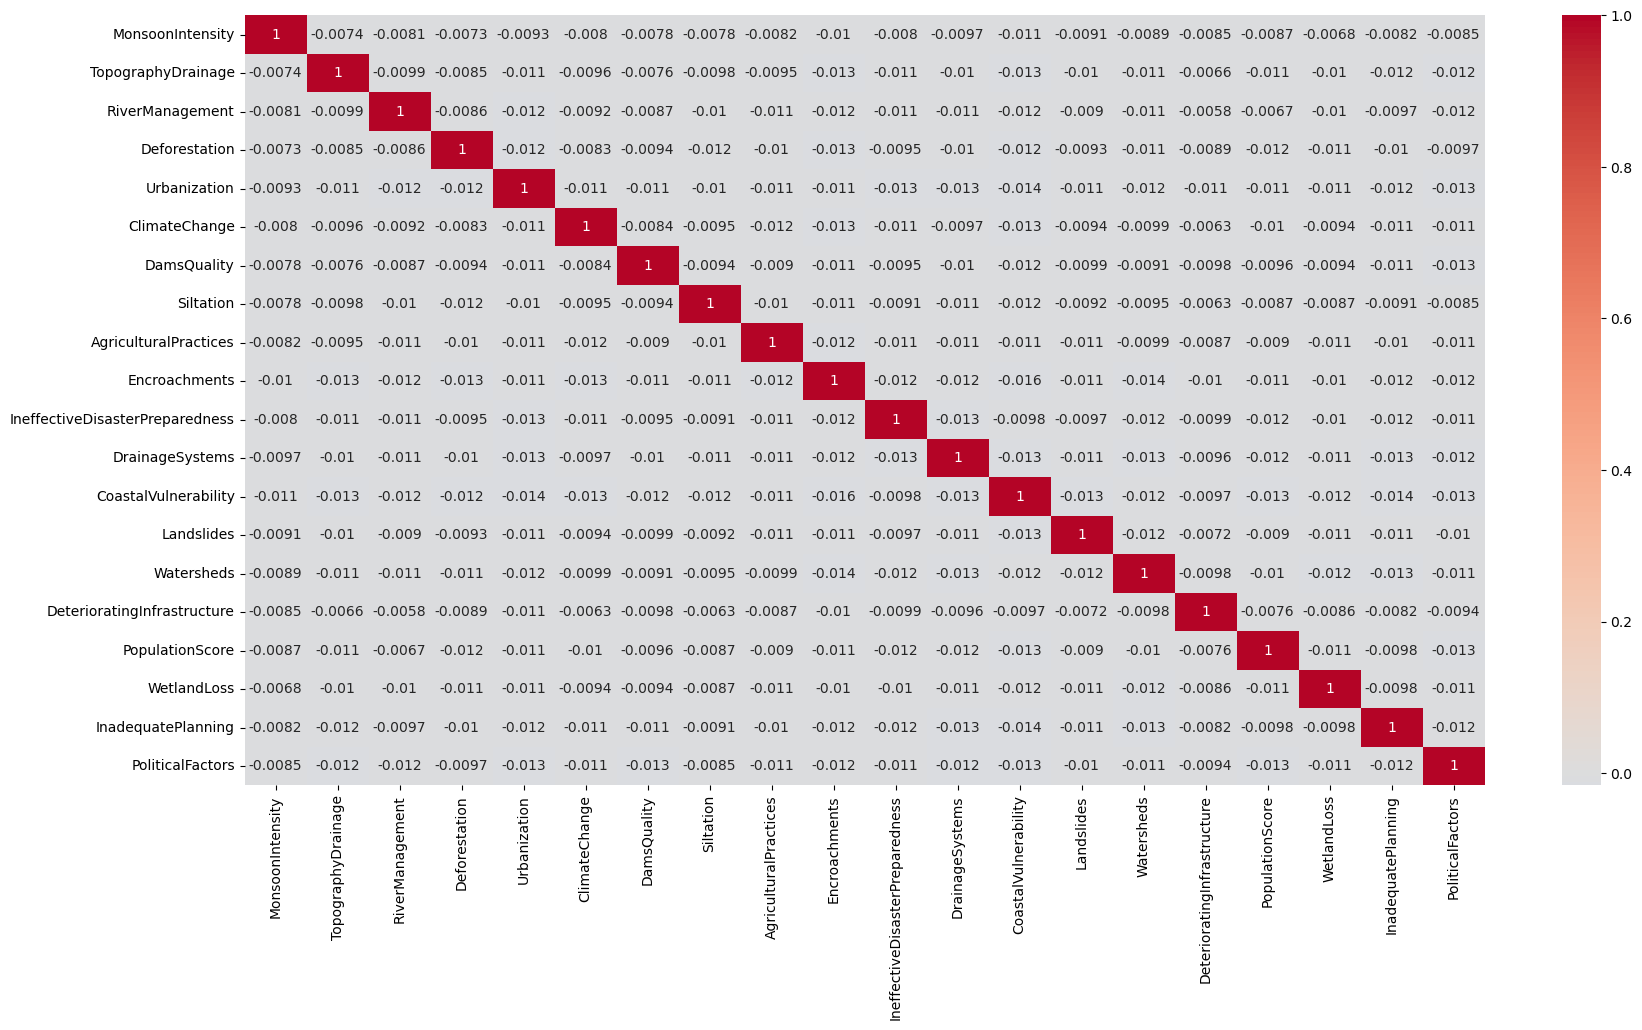

In [27]:
# Heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)
plt.show()


# Feature Engineering

In [12]:
def add_features(data):
    data['mean_feat'] = data.mean(axis=1)
    data['max_feat'] = data.max(axis=1)
    data['min_feat'] = data.min(axis=1)
    data['median_feat'] = data.median(axis=1)
    data['std_feat'] = data.std(axis=1)
    return data
   
data = add_features(data)


In [13]:
data.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,mean_feat,max_feat,min_feat,median_feat,std_feat
0,5,8,5,8,6,4,4,3,3,4,...,4,7,5,7,3,4.70,8.0,2.0,4.7,1.822146
1,6,7,4,4,8,8,3,5,4,6,...,5,3,3,4,3,4.70,9.0,0.0,4.0,2.477899
2,6,5,6,7,3,7,1,5,4,5,...,6,8,2,3,3,4.95,8.0,1.0,5.0,2.041178
3,3,4,6,5,4,8,4,7,6,8,...,4,6,5,7,5,5.20,8.0,2.0,5.0,1.735875
4,5,3,2,6,4,4,3,3,3,3,...,4,1,2,3,5,3.60,6.0,1.0,3.0,1.555542


In [14]:
data.describe()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,mean_feat,max_feat,min_feat,median_feat,std_feat
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,...,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,4.921450e+00,4.926671e+00,4.955322e+00,4.942240e+00,4.942517e+00,4.934093e+00,4.955878e+00,4.927791e+00,4.942619e+00,4.949230e+00,...,4.925907e+00,4.927520e+00,4.950859e+00,4.940587e+00,4.939004e+00,4.939411e+00,9.262722e+00,1.604034e+00,4.817401e+00,2.195905e+00
std,2.056387e+00,2.093879e+00,2.072186e+00,2.051689e+00,2.083391e+00,2.057742e+00,2.083063e+00,2.065992e+00,2.068545e+00,2.083324e+00,...,2.064813e+00,2.074176e+00,2.068696e+00,2.081123e+00,2.090350e+00,4.153644e-01,1.304840e+00,8.353827e-01,5.421162e-01,4.019993e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.150000e+00,4.000000e+00,0.000000e+00,2.000000e+00,7.777913e-01
25%,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,...,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.700000e+00,8.000000e+00,1.000000e+00,4.600000e+00,1.903200e+00
50%,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,4.900000e+00,9.000000e+00,2.000000e+00,5.000000e+00,2.153005e+00
75%,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.200000e+00,1.000000e+01,2.000000e+00,5.000000e+00,2.443314e+00
max,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.800000e+01,...,1.700000e+01,1.800000e+01,1.900000e+01,1.600000e+01,1.600000e+01,7.200000e+00,1.900000e+01,5.000000e+00,8.000000e+00,4.583720e+00


In [15]:
data = pd.concat([data, y], axis=1)
data.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,mean_feat,max_feat,min_feat,median_feat,std_feat,FloodProbability
0,5,8,5,8,6,4,4,3,3,4,...,7,5,7,3,4.70,8.0,2.0,4.7,1.822146,0.445
1,6,7,4,4,8,8,3,5,4,6,...,3,3,4,3,4.70,9.0,0.0,4.0,2.477899,0.450
2,6,5,6,7,3,7,1,5,4,5,...,8,2,3,3,4.95,8.0,1.0,5.0,2.041178,0.530
3,3,4,6,5,4,8,4,7,6,8,...,6,5,7,5,5.20,8.0,2.0,5.0,1.735875,0.535
4,5,3,2,6,4,4,3,3,3,3,...,1,2,3,5,3.60,6.0,1.0,3.0,1.555542,0.415


In [16]:
def outlier_removal(data):
    for columns in data.columns[:20]:
        data = data[data[columns]<13]
        #print(data[columns].value_counts().sort_index())
    return data
data = outlier_removal(data)

In [17]:
X = df.drop(columns=['FloodProbability'])
y = df['FloodProbability']

In [18]:
X.shape, y.shape

((1117957, 20), (1117957,))

In [19]:
def feature_scaling(X):
    #Standarization- Plotting values on same scale
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    # Fit scaler on training data and transform both training and testing data
    X= scaler.fit_transform(X)

    return X
X= feature_scaling(X)

In [20]:

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (894365, 20)

y_train shape: (894365,)

X_test shape: (223592, 20)

y_test shape: (223592,)


In [21]:
# X_train,X_test

In [22]:
# !pip install catboost

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score , KFold# kcross validation on every regresser
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'CatBoostRegressor': CatBoostRegressor(task_type="GPU", iterations=1000, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=100),
    'XGB Boost': XGBRegressor(tree_method="hist", device="cuda", max_depth=6,learning_rate=0.1,n_estimators=500, reg_lambda=3.0,verbosity=0,subsample=0.8,colsample_bytree=0.8),
    'LGBMRegressor': LGBMRegressor(device="gpu", num_leaves=40,max_depth=7,learning_rate=0.08,n_estimators=600, reg_lambda=2.0,random_state=42)
    #'Laso Regressor': Lasso(), #bad
    #'Decision Tree Regressor': DecisionTreeRegressor(),#bad
    }

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    print("Evaluating...")
    # Make predictions
    y_pred = model.predict(X_test)
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # Print results
    print(f"{name} Results:")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared (R2) Score: {r2}")
    print("---------------------------")


Training Linear Regression...

Evaluating...

Linear Regression Results:

Mean Absolute Error: 0.015792471363760305

Mean Squared Error: 0.0004032065870905581

R-squared (R2) Score: 0.8448773362840329

---------------------------

Training CatBoostRegressor...

0:	learn: 0.0503076	total: 20.7ms	remaining: 20.7s

100:	learn: 0.0247766	total: 1.45s	remaining: 12.9s

200:	learn: 0.0210434	total: 2.69s	remaining: 10.7s

300:	learn: 0.0202681	total: 3.88s	remaining: 9.02s

400:	learn: 0.0200656	total: 5.04s	remaining: 7.53s

500:	learn: 0.0199984	total: 6.18s	remaining: 6.16s

600:	learn: 0.0199632	total: 7.37s	remaining: 4.89s

700:	learn: 0.0199367	total: 8.52s	remaining: 3.63s

800:	learn: 0.0199114	total: 9.69s	remaining: 2.41s

900:	learn: 0.0198880	total: 10.9s	remaining: 1.2s

999:	learn: 0.0198650	total: 12.1s	remaining: 0us

Evaluating...

CatBoostRegressor Results:

Mean Absolute Error: 0.015804258679760437

Mean Squared Error: 0.0004001783895716127

R-squared (R2) Score: 0.846042

# Hyperparameter tunning GridsearchCV

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'CatBoostRegressor': CatBoostRegressor(task_type="GPU"),
    'XGB Boost': XGBRegressor(tree_method="hist", device="cuda"),
    'LGBMRegressor': LGBMRegressor(device="gpu")
    }
param_grids = {
    'Linear Regression': {
        'fit_intercept': [True, False],
    },
    'CatBoostRegressor': {
        'iterations': [1000, 1500],
        'depth': [6, 10],
        'learning_rate': [0.01, 0.1,0.2],
        'verbose': [100]
    },
    'XGB Boost': {
        'n_estimators': [500, 1000], # number of trees
        'max_depth': [3,10],
        'learning_rate': [0.01, 0.1,0.2],
    },
    'LGBMRegressor': {
        'n_estimators': [500,1000],
        'num_leaves': [31, 50, 100],
        'learning_rate': [0.01, 0.1, 0.2],
    },
}
best_models = {}
best_params = {}
best_scores = {}

for model_name, model in models.items():
    print(f"Training {model}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=3)
    grid_search.fit(X_train, y_train)
    
    best_models[model_name] = grid_search.best_estimator_
    best_params[model_name] = grid_search.best_params_
    best_scores[model_name] = grid_search.best_score_
    print(best_models,best_params,best_scores)

Training LinearRegression()...

{'Linear Regression': LinearRegression()} {'Linear Regression': {'fit_intercept': True}} {'Linear Regression': 0.8455646073870909}

Training <catboost.core.CatBoostRegressor object at 0x7e3197b03940>...

0:	learn: 0.0507782	total: 4.89ms	remaining: 4.89s

100:	learn: 0.0445788	total: 422ms	remaining: 3.75s

200:	learn: 0.0400365	total: 835ms	remaining: 3.32s

300:	learn: 0.0364927	total: 1.26s	remaining: 2.92s

400:	learn: 0.0337146	total: 1.67s	remaining: 2.5s

500:	learn: 0.0315001	total: 2.09s	remaining: 2.08s

600:	learn: 0.0296786	total: 2.52s	remaining: 1.67s

700:	learn: 0.0281519	total: 2.96s	remaining: 1.26s

800:	learn: 0.0268703	total: 3.4s	remaining: 844ms

900:	learn: 0.0257999	total: 3.82s	remaining: 420ms

999:	learn: 0.0249189	total: 4.25s	remaining: 0us

0:	learn: 0.0506918	total: 5.54ms	remaining: 5.54s

100:	learn: 0.0445416	total: 432ms	remaining: 3.84s

200:	learn: 0.0400263	total: 849ms	remaining: 3.38s

300:	learn: 0.0364982	total:

In [36]:
print(best_models,best_params,best_scores)
    

LGBMRegressor LGBMRegressor(device='gpu', n_estimators=1000)


# Test submission

In [90]:
df = pd.read_csv('./test.csv')
X_test = df.drop(columns=['id'])
ids = df['id']
X_test.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,4,6,3,5,6,7,8,7,8,4,8,5,7,5,6,3,6,4,4,5
1,4,4,2,9,5,5,4,7,5,4,2,4,7,4,5,1,7,4,4,3
2,1,3,6,5,7,2,4,6,4,2,7,9,2,5,5,2,3,6,8,3
3,2,4,4,6,4,5,4,3,4,4,7,8,4,6,7,6,4,2,4,4
4,6,3,2,4,6,4,5,5,3,7,4,3,2,6,4,6,8,4,5,5


In [91]:
X_test = add_features(X_test)
X_test = outlier_removal(X_test)
X_test= feature_scaling(X_test)

In [ ]:
models = {
    'CatBoostRegressor': CatBoostRegressor(depth= 6, iterations= 2000, learning_rate= 0.1, verbose= 100, task_type="GPU")
    }

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    print("Evaluating...")
    # Make predictions
    y_pred = model.predict(X_test)
    print("Done")
FloodProbability = y_pred.tolist()
ids = ids.tolist()

In [88]:
import csv

assert len(ids) == len(FloodProbability) #"The length of ImageId and labels must be the same."

# File name
file_name = 'test_submission_csv.csv'

# Writing to CSV
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id', 'FloodProbability'])  # Write header
    writer.writerows(zip(range(ids[0], ids[len(ids)-1]+1), FloodProbability))

print(f"Data written to {file_name} successfully.")

Data written to test_submission_csv.csv successfully.
